**Exercise 8.1**

In [180]:
import numpy, scipy.io, scipy.optimize, matplotlib.pyplot as plt

In [185]:
spamData = scipy.io.loadmat("data/spamData/spamData.mat")

In [188]:
ytrain = spamData['ytrain'].flatten()*2.-1.

In [110]:
xtrain = spamData['Xtrain']

In [12]:
xStand = (xtrain - xtrain.mean(axis=0))/numpy.sqrt(xtrain.var(axis=0))

In [13]:
xLog = numpy.log(xtrain+0.1)

In [434]:
xBin = (xtrain > 0).astype(float)

We first fit a general $l_2$-regularized model and then minimize MSE using cross validation to find the optimal regularizer strength.

In [334]:
def target(w, x, y, lam):
    wt = x@w
    nll = numpy.log(1+numpy.exp(-y*wt))
    return numpy.sum(nll) + lam*(w@w)

In [743]:
def jac(w, x,y, lam):
    wt = x@w
    mu = 1./(1.+numpy.exp(-wt))
    return x.T@(mu - (y + 1)/2) + lam*w

In [437]:
# BFGS seems to be faster than any solver using this information
def hess(w, x, lam):
    wt = x@w
    mu = 1./(1.+numpy.exp(-wt))
    s = numpy.diag(mu*(1-mu))
    return x.T@s@x + numpy.identity(len(mu))

In [408]:
def getKfoldTrainingIndices(i, k):
    mask = numpy.ones_like(ytrain, dtype=numpy.dtype('bool'))
    #mask[int(len(mask)/k*i):int(len(mask)/k*(i+1))] = False
    falseIdx = numpy.array(range(int(len(mask)/k))) * k + i
    mask[falseIdx] = False
    return mask

In [407]:
def getNoMiscalculated(x, y, w):
    ypred = numpy.round(1./(1.+numpy.exp(-x@w)))*2 - 1
    return (numpy.where(numpy.abs(ypred - y) > 0)[0].shape)[0]

In [413]:
def crossValidate(x, y, foldIdx, lam, k):
    mm = getKfoldTrainingIndices(foldIdx, k)
    w0 = numpy.ones((57))
    res = scipy.optimize.minimize(target, w0/100, args=(x[mm], y[mm], lam), jac=jac)
    return getNoMiscalculated(x[numpy.logical_not(mm)], y[numpy.logical_not(mm)], res['x'])

In [420]:
def crossValidateAll(x,y,lam,k):
    noMisses = 0
    for i in range(k):
        noMisses += crossValidate(x, y, i, lam,k)
    return noMisses

In [431]:
def sweepLam(x,y, k):
    noSweeps = 8
    missRate = numpy.array(range(noSweeps))*1.0-5
    lams = 10**missRate
    for i, lam in enumerate(lams):
        missRate[i] = crossValidateAll(x,y,lam,k)/len(y)
    return lams, missRate

In [432]:
sweepLam(xStand, ytrain, 5)

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([0.07928222, 0.07928222, 0.07960848, 0.07830343, 0.08319739,
        0.08352365, 0.08482871, 0.0867863 ]))

In [433]:
sweepLam(xLog, ytrain, 5)

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([0.05807504, 0.05840131, 0.05840131, 0.05840131, 0.05676998,
        0.05513866, 0.05611746, 0.06590538]))

In [436]:
sweepLam(xBin, ytrain,5)

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([0.0721044 , 0.07177814, 0.07177814, 0.07177814, 0.07079935,
        0.07079935, 0.07014682, 0.091354  ]))

 We can now fit the whole model and compute the miscalculation rate on the training data but I can't be stuffed to do that now (it's trivial).

**Exercise 8.2.** Use naive Bayes instead

(a) using binary features

$$
P(y=c|\boldsymbol{x},\boldsymbol{\theta}) = \frac{P(\boldsymbol{x}|y=c, \boldsymbol{\theta})P(y=c)}{\sum_{c'} P(\boldsymbol{x}|y=c', \boldsymbol{\theta})P(y=c')}
= \frac{\prod_i P(x_i|y=c, \boldsymbol{\theta}) P(y=c)}{\sum_{c'} P(\boldsymbol{x}|y=c', \boldsymbol{\theta})P(y=c')}
$$

We use a plug-in approximation for $\boldsymbol{\theta}$ and $P(y=c)$ that we get from the MLE. As this is a binary classifier
we have the class-conditional probability for an individual observation $j$

$$
P(x_i^{(j)}|y^j=c) = \theta_i^{x_i^{(j)}} (1-\theta_i)^{1-x_i^{(j)}}
$$

so the likelihood is given by

$$
\begin{align}
\mathrm{LL}(\boldsymbol{\theta}) &= \sum_j \sum_i \left[{x_i^{(j)}} \log \theta_i + (1-{x_i^{(j)}}) \log (1-\theta_i)\right] + \sum_j \left[{y^{(j)}} \log \pi + (1-{y^{(j)}}) \log (1-\pi)\right]
\end{align}
$$

That means the MLE is just the relative number of counts in each category, i.e.

$$
\hat{\theta}_{i,1} = \frac{N_{i,1}}{N_1}
$$

and

$$
\hat{\pi} = \frac{N_s}{N}
$$

In [440]:
N = ytrain.shape[0]

In [582]:
xBin1 = xBin[ytrain > 0, :]

In [583]:
xBin0 = xBin[ytrain < 0, :]

In [584]:
theta1 = numpy.sum(xBin1, axis=0)/xBin1.shape[0]

In [585]:
theta0 = numpy.sum(xBin0, axis=0)/xBin0.shape[0]

In [586]:
pi = numpy.sum(ytrain+1)/(2*N)

The last three columns are always one, so we omit them from the model.

In [590]:
ypred0 = numpy.prod((theta0**xBin * (1-theta0)**(1-xBin)*pi)[:,:-3], axis=1)

In [591]:
ypred1 = numpy.prod((theta1**xBin * (1-theta1)**(1-xBin)*pi)[:,:-3], axis=1)

In [592]:
ypred = numpy.round(ypred1/(ypred0 + ypred1))*2 - 1

In [593]:
(numpy.where(numpy.abs(ypred - ytrain) > 0)[0].shape)[0]/N

0.10831973898858074

(b) Gaussian

The class-conditional probability is just an MVN with diagonal covariance matrix:

$$
P(\boldsymbol{x}|\boldsymbol{\theta}, c) = \mathcal{N}(\boldsymbol{\mu}_c, \boldsymbol{\Sigma}_c).
$$


The MLE estimate is just the MVN-MLE for each class separately.

In [595]:
xBin0 = None

In [596]:
xBin1 = None

In [597]:
xBin = None

In [594]:
xStand1 = xStand[ytrain > 0, :]

In [598]:
xStand0 = xStand[ytrain < 0, :]

In [599]:
mu0 = numpy.mean(xStand0, axis=0)

In [600]:
mu1 = numpy.mean(xStand1, axis=0)

In [601]:
sigma0 = numpy.var(xStand0, axis=0)

In [602]:
sigma1 = numpy.var(xStand1, axis=0)

In [603]:
import scipy.stats

In [604]:
mvn0 = scipy.stats.multivariate_normal(mu0[:-3], numpy.diag(sigma0[:-3]))

In [605]:
mvn1 = scipy.stats.multivariate_normal(mu1[:-3], numpy.diag(sigma1[:-3]))

In [606]:
ypred = numpy.round(mvn1.pdf(xStand[:,:-3])/(mvn1.pdf(xStand[:,:-3]) + mvn0.pdf(xStand[:,:-3])))*2.-1.

In [607]:
(numpy.where(numpy.abs(ypred - ytrain) > 0)[0].shape)[0]/N

0.18140293637846655

Fully Gaussian:

In [608]:
numpy.cov(xStand0[:,:-3], rowvar = False).shape

(54, 54)

In [609]:
mvn0 = scipy.stats.multivariate_normal(mu0[:-3], numpy.cov(xStand0[:,:-3], rowvar=False))

In [610]:
mvn1 = scipy.stats.multivariate_normal(mu1[:-3], numpy.cov(xStand1[:,:-3], rowvar=False))

In [611]:
ypred = numpy.round(mvn1.pdf(xStand[:,:-3])/(mvn1.pdf(xStand[:,:-3]) + mvn0.pdf(xStand[:,:-3])))*2.-1.

<ipython-input-611-e62b324be7e7>:1: RuntimeWarning: invalid value encountered in true_divide
  ypred = numpy.round(mvn1.pdf(xStand[:,:-3])/(mvn1.pdf(xStand[:,:-3]) + mvn0.pdf(xStand[:,:-3])))*2.-1.


In [613]:
(numpy.where(numpy.abs(ypred - ytrain) > 0)[0].shape)[0]/N

0.16182707993474715

**Exercise 8.3**

(a) 
$$
\sigma(a) = \frac{1}{1+\exp(-a)}
$$

$$
\begin{align}
\frac{\mathrm{d}}{\mathrm{d}a} \sigma(a)
&= \frac{-\exp(-a)}{[1+\exp(-a)]^2} \\
&= \sigma(a) \frac{-\exp(-a)}{1+\exp(-a)} \\
&= \sigma(a) \left[1-\sigma(a)\right]
\end{align}
$$

(b)

$$
P(y|\boldsymbol{x}, \boldsymbol{w}) = \sigma(\boldsymbol{w}^T \boldsymbol{x}_i)^y \left[1-\sigma(\boldsymbol{w}^T \boldsymbol{x}_i)\right]^{1-y}
$$

$$
\begin{align}
\mathrm{LL}(\boldsymbol{w})
&= \sum_i y_i \log \sigma(\boldsymbol{w}^T \boldsymbol{x}_i) + (1-y_i) \log \left[1-\sigma(\boldsymbol{w}^T \boldsymbol{x}_i)\right]
\end{align}
$$

$$
\begin{align}
\frac{\partial}{\partial w_j} \mathrm{LL}(\boldsymbol w)
&= \sum_i \left\{ y_i \frac{\sigma(\boldsymbol{w}^T \boldsymbol{x}_i) \left[1-\sigma(\boldsymbol{w}^T \boldsymbol{x}_i)\right]}{\sigma(\boldsymbol{w}^T \boldsymbol{x}_i)} (\boldsymbol{x}_i)_j - (1-y_i) \frac{\sigma(\boldsymbol{w}^T \boldsymbol{x}_i) \left[1-\sigma(\boldsymbol{w}^T \boldsymbol{x}_i)\right]}{1-\sigma(\boldsymbol{w}^T \boldsymbol{x}_i)} (\boldsymbol{x}_i)_j \right\} \\
&= \sum_i \left\{ y_i \left[1-\sigma(\boldsymbol{w}^T \boldsymbol{x}_i)\right] (\boldsymbol{x}_i)_j - (1-y_i) \sigma(\boldsymbol{w}^T \boldsymbol{x}_i) (\boldsymbol{x}_i)_j \right\} \\
&= \sum_i (\boldsymbol{x}_i)_j \left[ y_i -  y_i \sigma(\boldsymbol{w}^T \boldsymbol{x}_i)  - \sigma(\boldsymbol{w}^T \boldsymbol{x}_i) + y_i \sigma(\boldsymbol{w}^T \boldsymbol{x}_i) \right] \\
&= \sum_i (\boldsymbol{x}_i)_j \left[ y_i - \sigma(\boldsymbol{w}^T \boldsymbol{x}_i) \right] \\
&= \boldsymbol{X}^T (\boldsymbol{y} - \boldsymbol{\mu})
\end{align}
$$

Note that this is the likelihood, so negative likelihood as in (8.5) has opposite sign.

(c)

To show:

1.
$$
\boldsymbol{H}^T = (\boldsymbol{X}^T \boldsymbol{S} \boldsymbol{X})^T = \boldsymbol{X}^T \boldsymbol{S} \boldsymbol{X} = \boldsymbol{H}
$$

This is also obvious from the definition of the Hermitian matrix.

2.
$$
\begin{align}
\boldsymbol{H}
&= \boldsymbol{X}^T \sqrt{\boldsymbol{S}} \sqrt{\boldsymbol{S}}  \boldsymbol{X} \\
&= \boldsymbol{X}^T \sqrt{\boldsymbol{S}}^T \sqrt{\boldsymbol{S}} \boldsymbol{X} \\
&= (\sqrt{\boldsymbol{S}} \boldsymbol{X})^T \sqrt{\boldsymbol{S}} \boldsymbol{X} \\
\end{align}
$$

Since $\boldsymbol{X}$ has full rank it prooves the positive-definiteness of the matrix.

**Exercise 8.4.**
Let $\boldsymbol{W} = \begin{pmatrix} \boldsymbol{w}_1 \cdots \boldsymbol{w}_C \end{pmatrix}$.

$$
\mu_{ic} = S(\boldsymbol{\eta}_i)_c = S(\boldsymbol{W}^T \boldsymbol{x}_i)_c = \frac{\exp(\boldsymbol{w}_c^T \boldsymbol{x})}{\sum_{c'} \exp(\boldsymbol{w}_{c'}^T \boldsymbol{x})}
$$

Also, we have
$$
\eta_{ij} = (\boldsymbol{W}^T \boldsymbol{x}_i)_j = \boldsymbol{w}^T_j \boldsymbol{x}_i
$$

We have $D(C-1)$ unknowns $w_{c,l}$.

a)

$$
\begin{align}
\frac{\partial}{\partial \eta_{ij}} \mu_{ic}
&= - \frac{\exp(\boldsymbol{w}_c^T \boldsymbol{x})\exp(\boldsymbol{w}_j^T \boldsymbol{x})}{\left[\sum_{c'} \exp(\boldsymbol{w}_{c'}^T \boldsymbol{x})\right]^2} + \delta_{jc} \frac{\exp(\boldsymbol{w}_c^T \boldsymbol{x})}{\sum_{c'} \exp(\boldsymbol{w}_{c'}^T \boldsymbol{x})} \\
&= \delta_{jc} \mu_{ic} - \mu_{ic} \mu_{ij} \\
&= \mu_{ic} (\delta_{jc} - \mu_{ij})
\end{align}
$$

b)

$$
l(\boldsymbol{W}) = \sum_i \sum_c y_{ic} \log \mu_{ic}
$$

$$
\begin{align}
\frac{\partial}{\partial w_{kl}} l(\boldsymbol{W})
&= \sum_i \sum_{c} y_{ic} \frac{1}{\mu_{ic}} \frac{\partial}{\partial w_{kl}} \mu_{ic} \\
&= \sum_i \sum_{c} y_{ic} \frac{1}{\mu_{ic}} \frac{\partial \mu_{ic}}{\partial \eta_{ik}} \frac{\partial \eta_{ik}}{\partial w_{kl}} \\
&= \sum_i \sum_{c} y_{ic} \frac{1}{\mu_{ic}} \mu_{ic} (\delta_{ck} - \mu_{ik}) x_{il} \\
&= \sum_i \sum_{c} y_{ic} (\delta_{ck} - \mu_{ik}) x_{il} \\
&= \sum_i  (y_{ik} - \mu_{ik}) x_{il} \\
\end{align}
$$

c)

$$
\begin{align}
H_{(c,l), (c',l')}
&= \frac{\partial^2}{\partial w_{c,l} \partial w_{c',l'}} l(\boldsymbol{W}) \\
&= \sum_i \frac{\partial}{\partial w_{c',l'}} (y_{ic} - \mu_{ic}) x_{il} \\
&= \sum_i - x_{il} \frac{\partial}{\partial w_{c',l'}} \mu_{ic}  \\
&= \sum_i - x_{il} \frac{\partial \mu_{ic}}{\partial \eta_{ic'}} \frac{\partial}{\partial w_{c',l'}} \eta_{ic'} \\
&= \sum_i - x_{il} \mu_{ic} (\delta_{cc'} - \mu_{ic'}) x_{il'} \\
&= \sum_i  \mu_{ic} (\mu_{ic'} - \delta_{cc'}) x_{il'} x_{il} \\
\end{align}
$$

So in matrix form

$$
\boldsymbol{H} = \sum_i \left[\boldsymbol{\mu}_i \boldsymbol{\mu}_i^T - \mathrm{diag}(\boldsymbol{\mu}_i)\right] \otimes \boldsymbol{x}_i \boldsymbol{x}_i^T
$$

**Exercise 8.7**
We recreate the data and the sketch so we can make plots.

In [626]:
xtrain = numpy.array(
[
    [1.5, 5.75],
    [2.25, 0.75],
    [2.5, 4.5],
    [2.25, 5.75],
    [3.5, 5.25],
    [3.5, 6.25],
    [5.5, 1.1],
    [5.5, 2.25],
    [5.5, 4.25],
    [6.5, 1.1],
    [6.5, 2],
    [7.8, 1.1],
    [7.5, 2.2]
])

In [625]:
ytrain = numpy.array([0,0,0,0,0,0,1,1,1,1,1,1,1])

In [616]:
%matplotlib inline

In [630]:
%config InlineBackend.close_figures=False 

In [734]:
plt.clf()

In [735]:
plt.plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], "ob", xtrain[ytrain==1,0], xtrain[ytrain==1,1], "xr")

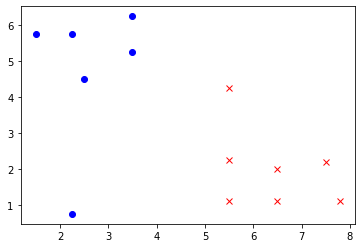

In [736]:
plt.show()

Decision boundary in logistic regression is always an expression like

$$
\boldsymbol{w}^T \boldsymbol{x} = c_0
$$

so in this case we have

$$
\begin{align}
w_0 + w_1 x_1 + w_2 x_2 & = c_0 \\
x_2 &= - \frac{w_1}{w_2} x_1 + \frac{c_0 - w_0}{w_2} \\
x_2 &= - \frac{w_1}{w_2} x_1 + \frac{1}{2 w_2} - \frac{w_0}{w_2}
\end{align}
$$

A simple decision boundary would be a line going through the points $(3,0)$ and $(5,6)$, say. Even if we fix $c_0 = 1/2$, as above, we can only specify the parameters $m=-w_1/w_2$ and the offset $b=1/(2 w_2) - w_0/w_2$. In this case,

$$
x_2 = 3 x_1 - 9
$$

In [737]:
plt.plot([3,5], [0,6], "-")

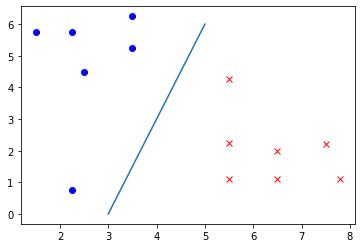

In [738]:
plt.show()

we can also properly fit it using the functions above

In [685]:
xtp = numpy.c_[numpy.ones_like(ytrain), xtrain]

In [718]:
res = scipy.optimize.minimize(target, numpy.array([0,0,0]), args=(xtp, ytrain*2-1, 0), jac=jac)

In [722]:
w = res['x']

In [723]:
m = -w[1]/w[2]

In [724]:
b = 1/(2*w[2])-w[0]/w[2]

In [739]:
plt.plot([4,4.5], [4.0 * m + b, 4.5 * m + b], "g-")

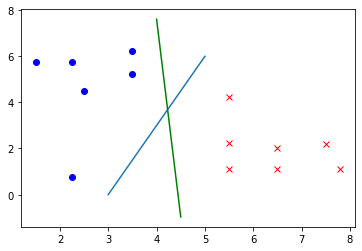

In [740]:
plt.show()

Regularizing on $w_0$ means that the boundary contains the origin of the plot so we can only pick the incline. Of course we could just shift the feature coordinates in order to achieve optimal separation.

In [885]:
def t2(w, x, y, lam, regidx):
    wt = x@w
    nll = numpy.log(1+numpy.exp(-y*wt))
    return numpy.sum(nll) + lam*w[regidx]**2

In [886]:
def j2(w, x,y, lam, regidx):
    wt = x@w
    mu = 1./(1.+numpy.exp(-wt))
    jac = numpy.zeros_like(w)
    jac[regidx] = lam * w[regidx]
    return x.T@(mu - (y + 1)/2) + jac

In [905]:
res = scipy.optimize.minimize(t2, numpy.array([0,0,0]), args=(xtp, ytrain*2-1, 100, 0), jac=j2)

In [906]:
res

      fun: 2.32435194596563
 hess_inv: array([[ 0.00994532, -0.0009145 , -0.00113553],
       [-0.0009145 ,  0.30764476, -0.30405275],
       [-0.00113553, -0.30405275,  0.40275341]])
      jac: array([ 1.85586535e-06, -9.90754047e-07,  6.13593568e-07])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 16
     njev: 20
   status: 0
  success: True
        x: array([-0.00568814,  1.00234898, -1.13564863])

In [891]:
w = res['x']

In [892]:
m = -w[1]/w[2]

In [893]:
b = 1/(2*w[2])-w[0]/w[2]

In [894]:
plt.clf()

In [895]:
plt.plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], "ob", xtrain[ytrain==1,0], xtrain[ytrain==1,1], "xr")

In [896]:
plt.plot([0,4.5], [0.0 * m + b, 4.5 * m + b], "g-")

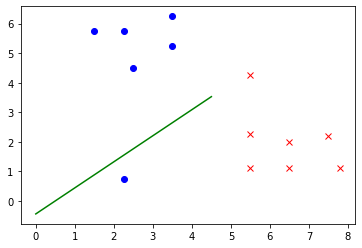

In [897]:
plt.show()

Regularizing on $w_1$ means that we have only $x_2$ as information, so the separation boundary is a horizontal line.

In [916]:
res = scipy.optimize.minimize(t2, numpy.array([1,0,1]), args=(xtp, ytrain*2-1, 100, 1), jac=j2)

In [917]:
res

      fun: 5.602506986802153
 hess_inv: array([[ 2.75649889, -0.0539947 , -0.5931563 ],
       [-0.0539947 ,  0.00878287,  0.00423628],
       [-0.5931563 ,  0.00423628,  0.17486948]])
      jac: array([-3.50623058e-08,  1.38547071e-06,  1.91769864e-07])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([ 2.67469264,  0.06004781, -0.84929082])

In [918]:
w = res['x']

In [919]:
m = -w[1]/w[2]

In [920]:
b = 1/(2*w[2])-w[0]/w[2]

In [921]:
plt.clf()

In [922]:
plt.plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], "ob", xtrain[ytrain==1,0], xtrain[ytrain==1,1], "xr")

In [923]:
plt.plot([0,4.5], [0.0 * m + b, 4.5 * m + b], "g-")

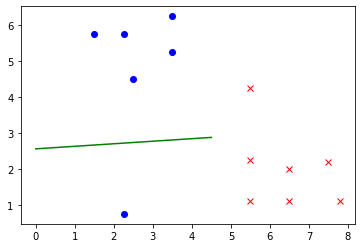

In [924]:
plt.show()

Similarly, if we regularize on $w_2$ we would get a vertical line:

In [925]:
res = scipy.optimize.minimize(t2, numpy.array([1,1,0]), args=(xtp, ytrain*2-1, 100, 2), jac=j2)

In [926]:
res

      fun: 5.822362294575155e-06
 hess_inv: array([[ 1.20701489e+06, -2.68048023e+05, -1.07477776e-01],
       [-2.68048023e+05,  5.95268313e+04,  1.86118528e-02],
       [-1.07477776e-01,  1.86118528e-02,  7.21737861e-03]])
      jac: array([-5.03780063e-08, -6.04906398e-06,  8.71638408e-06])
  message: 'Optimization terminated successfully.'
     nfev: 29
      nit: 24
     njev: 29
   status: 0
  success: True
        x: array([-6.11988300e+01,  1.36428689e+01, -4.39260540e-09])

In [927]:
w = res['x']

In [928]:
m = -w[1]/w[2]

In [929]:
b = 1/(2*w[2])-w[0]/w[2]

In [968]:
plt.clf()

In [969]:
plt.plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], "ob", xtrain[ytrain==1,0], xtrain[ytrain==1,1], "xr")

In [970]:
plt.plot([4.522423424404185,4.522423427623893], [4.522423424404185 * m + b, 4.522423427623893 * m + b], "g-")

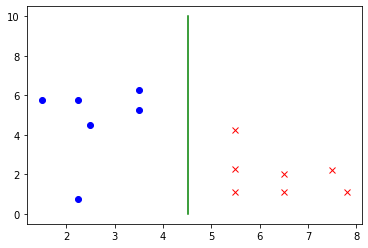

In [971]:
plt.show()